<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 3 - Aplicaciones de Redes Neuronales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Modelos Generativos profundos: VAE (*Variational Autoencoder*) y GAN (*Generative Adversarial Network*).
* Arquitectura encoder-decoder y mecanismo de antención.
* Desafío en donde se aplique todo lo aprendido.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: -
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Modelos Generativos  
[2.](#segundo) *Question-Answering*  
[3.](#tercer) Challenge (*Object Counting*)

*Nota: Para esta actividad, al igual que anteriores, si es que no se cuenta con GPU se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__*

In [65]:
import pandas as pd
from nltk.tokenize import word_tokenize
import numpy as np
from keras.preprocessing import sequence
from keras.layers import Input,RepeatVector,TimeDistributed,Dense,Embedding,Flatten,Activation,Permute,Lambda,CuDNNLSTM,CuDNNGRU,Bidirectional,Dropout
from keras.models import Model
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from tqdm import tqdm
import nltk
from numpy.random import choice
nltk.download('punkt')
from keras import regularizers
import json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#2. Get the file
downloaded = drive.CreateFile({'id':'1iQngzTfVhImh7rvNFUYp3KrEjx4JHn_g'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train_Q-A.csv')  
downloaded = drive.CreateFile({'id':'1-QWhbVlVYOBF1GbAtzpxkxzg9XELzi4p'}) # replace the id with id of file you want to access
downloaded.GetContentFile('test_Q.csv') 
downloaded = drive.CreateFile({'id':'1E1dhpFRrJK3wI2Q5b8JA1PmIHL7kPHw0'})
downloaded.GetContentFile('evaluate-v2.0.py') 
downloaded = drive.CreateFile({'id':'1a-Yzu8zKJb_vfCEWFsLHY-3bRG-04oJt'})
downloaded.GetContentFile('dev-v2.0.json')

<a id="segundo"></a>
## 2. *Question Answering*

Las redes neuronales recurrentes hoy en día han sido aplicadas a varios problemas que involucra dependencia temporal de los datos de entrada, en textos por lo común, tal como los modelos *sequence to sequence* de traducción, resumir textos, formular hipótesis de un extracto o, como veremos en esta actividad, generar respuesta en base a alguna pregunta. En imágenes también han sido aplicadas, ya sea a procesamiento de videos u a otro problema en que las imágenes tienen dependencia temporal unas con otras.

Para ésta actividad trabajaremos el dataset de __[SQuAD2.0](https://rajpurkar.github.io/SQuAD-explorer/)__  (The Stanford Question Answering Dataset), los datos se los entregamos en formato *csv*, sin ningún preprocesamiento, para que sea mas fácil la lectura. La tarea como ya se comentó consiste en predecir una respuesta (secuencia de palabras) que contesten una pregunta también en forma de secuencia de palabras, con un enfoque *encoder-decoder* con módulos de antención.


<img src="https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2017/07/20/sockeye_1.gif" title="Attention" width="65%" style="float: right;"/>


<img src="http://www.wildml.com/wp-content/uploads/2015/12/Screen-Shot-2015-12-30-at-1.16.08-PM.png" title="Attention" width="35%" style="float: left;"/>



Los módulos de antención [[6]](#refs) son una variación a la arquitectura *encoder-decoder* en donde se agrega que para cada instante de tiempo de la **decodificación** $T'$ hay una combinación lineal del vector de codificación en todos los instantes tiempo $T$, ésto es para que en cada instante de tiempo de la decodificación se ponga atención a cierta información en toda la secuencia de entrada. 


$$
y_{T'} = \sum_{t}^{T} \alpha_{T',t} \cdot h_t^{codificacion}
$$

> a) Carge los datos y descríbalos ¿Cuántos ejemplos se tienen para entrenar y para predecir?

```python
import pandas as pd
df_train = pd.read_csv('SQuAD/train_Q-A.csv')
df_train.dropna(inplace=True)
df_test = pd.read_csv('SQuAD/test_Q.csv')
df_train.head()
df_train.shape
```

In [4]:
df_train = pd.read_csv('train_Q-A.csv')
#Eliminar entradas con valores nulos
df_train.dropna(inplace=True)
df_test = pd.read_csv('test_Q.csv')
df_train.head()

,id,question,answer
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,in the late 1990s
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,singing and dancing
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,2003
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"Houston, Texas"
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,late 1990s


In [5]:
df_train.shape

(86821, 3)

In [6]:
df_test.head()

,id,question
0,56ddde6b9a695914005b9628,In what country is Normandy located?
1,56ddde6b9a695914005b9629,When were the Normans in Normandy?
2,56ddde6b9a695914005b962a,From which countries did the Norse originate?
3,56ddde6b9a695914005b962b,Who was the Norse leader?
4,56ddde6b9a695914005b962c,What century did the Normans first gain their ...


In [7]:
df_test.shape

(11873, 2)

Los datos de entrenamiento consisten en 86821 preguntas y respuestas (e id correspondiente) sacadas de artículos de Wikipedia.
Los datos de prueba corresponden a 11873 preguntas.

> b) Realice un preprocesamiento simple a los textos de entrada (preguntas) *tokenizandolos* y pasando a minúsculas para evitar ambiguedad, si desea agregar algun preprocesamiento éxtra ésto se verá reflajado en su nota. A los textos de salida (respuestas) no realice ningún preprocesamiento mas que *tokenizar*, puesto que para la evaluación se solicita retornar los textos en su forma natural. Comente lo realizado.

```python
from nltk.tokenize import word_tokenize
train_questions = [word_tokenize(sentence.lower()) for sentence in df_train["question"]] #or processing
test_questions = [word_tokenize(sentence.lower()) for sentence in df_test["question"]]
train_answers = [word_tokenize(sentence) for sentence in df_train["answer"]]
```

Para utilizar el tokenizador fue necesario descargar el corpus del modelo. Para ello se utilizó:

```python
import nltk
nltk.download('punkt')
```

In [8]:
train_questions = [word_tokenize(sentence.lower()) for sentence in tqdm(df_train["question"])] #or processing
test_questions = [word_tokenize(sentence.lower()) for sentence in tqdm(df_test["question"])]
train_answers = [word_tokenize(sentence) for sentence in tqdm(df_train["answer"])]

100%|██████████| 86821/86821 [00:09<00:00, 8981.26it/s]


In [9]:
nQuestions = 0
sample = True
nonQuestion = ""

for i in tqdm(range(len(train_questions))):
    question = train_questions[i]
    if '?' in question:
        nQuestions += 1
    else:
        if sample:
            nonQuestion = question
            sample = False

print('Number of questions with the question sign: ',nQuestions)
print('Example of non question question: ', nonQuestion)

100%|██████████| 86821/86821 [00:00<00:00, 1156248.94it/s]

Number of questions with the question sign:  85893
Example of non question question:  ['what', 'song', 'did', 'beyoncé', 'perform', 'at', 'the', 'first', 'inaugural', 'dance', 'for', 'the', 'obamas', '.']


Las mayoría de las preguntas tienen el signo de pregunta, y las que no lo poseen tienen la misma estructura. Es decir el signo de pregunta no añade információn relevante a la entrada.
Por lo anterior, se eliminarán estos signos.

In [10]:
for i in tqdm(range(len(train_questions))):
    if '?' in train_questions[i]:
        train_questions[i][:] = [lemma for lemma in train_questions[i] if lemma != '?']

100%|██████████| 86821/86821 [00:00<00:00, 482681.39it/s]


In [11]:
nQuestions = 0
sample = True

for i in tqdm(range(len(train_questions))):
    question = train_questions[i]
    if '?' in question:
        nQuestions += 1
        
print('Number of questions with the question sign: ',nQuestions)

100%|██████████| 86821/86821 [00:00<00:00, 1239397.81it/s]

Number of questions with the question sign:  0


100%|██████████| 86821/86821 [00:00<00:00, 1414507.61it/s]


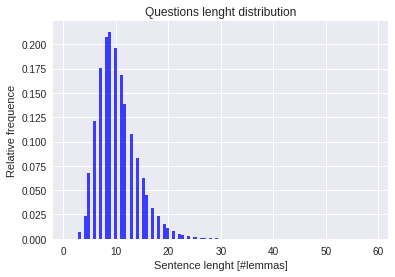

mu=10.30, sigma=3.71


In [12]:
largos = []

for i in tqdm(range(len(train_questions))):
    largos.append(len(train_questions[i]))

sigma = np.std(largos)
mu = np.average(largos)

# the histogram of the data
n, bins, patches = plt.hist(largos, 100, normed=1, facecolor='blue', alpha=0.75)

titulo = 'mu={0:.2f}, sigma={1:.2f}'.format(mu,sigma)

plt.xlabel('Sentence lenght [#lemmas]')
plt.ylabel('Relative frequence')
plt.title('Questions lenght distribution')
plt.grid(True)

plt.show()

print(titulo)

El largo de las preguntas oscila entre $10.30\pm 3.72$ lemmas.

In [13]:
lemas = set()
for i in tqdm(range(len(train_questions))):
    for lema in train_questions[i]:
        lemas.add(lema)

lemas = list(lemas)    
    
print("Ammount of lemas:", len(lemas))

100%|██████████| 86821/86821 [00:00<00:00, 316210.74it/s]

Ammount of lemas: 39480


In [0]:
i=0

Nlemas = np.empty(len(lemas))

for lema in tqdm(lemas):
    Nlemas[i]= sum(question.count(lema) for question in train_questions)
    i+=1

Existen 39480 lemas distintos

In [14]:
sortedLemmas = sorted(zip(lemas,Nlemas), reverse=True, key=lambda pair: pair[1])
nTop = 10
i=0
print('{0:^20}|{1:^15}'.format('Lemma', 'Ammount'))
print('-'*36)
for (l, n) in sortedLemmas:
  print('{0:^20}|{1:^15.0f}'.format(l, n))
  i+=1
  if i >= nTop:
    break

       Lemma        |    Ammount    
------------------------------------
        the         |     64120     
        what        |     50504     
         of         |     34132     
         in         |     26109     
         to         |     18777     
        was         |     17199     
         is         |     16416     
        did         |     15838     
         a          |     11162     
        how         |     9450      


Como es de esperar las palabras más comunes de las preguntas corresponden a artículos, conjunciones e inicios de preguntas como 'what', 'how', 'did', 'was'.

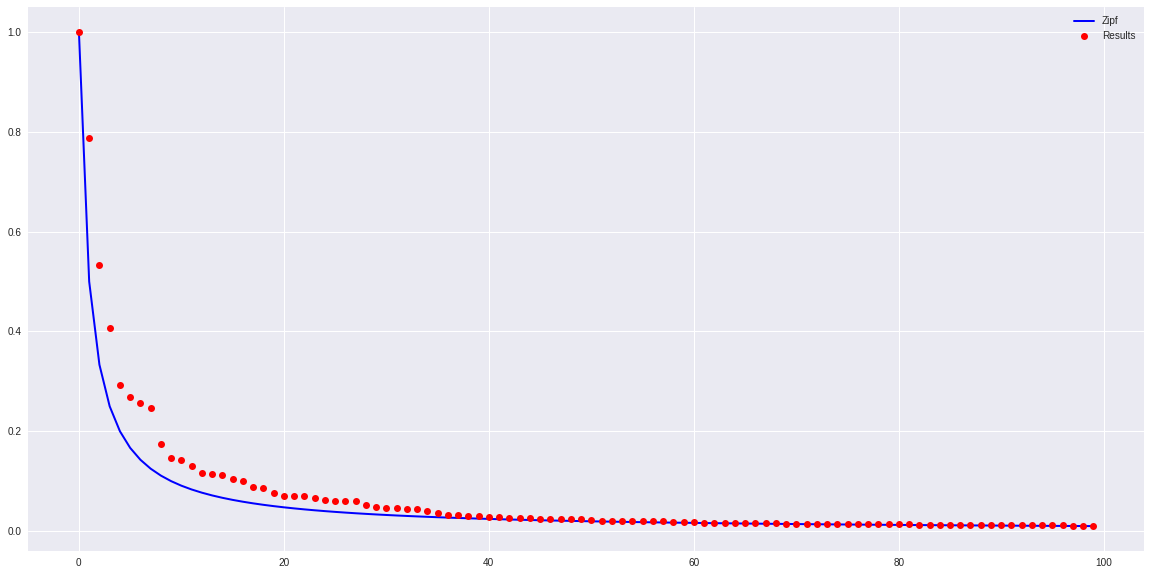

In [15]:
max_repeat = sortedLemmas[0][1]
plt.figure(figsize=(20,10))
plt.plot(list(range(100)), [1/(i+1) for i in range(100)], 'b-', linewidth=2, label='Zipf')
plt.plot(list(range(100)), [y/max_repeat for (_, y) in sortedLemmas[0:100]], 'ro', label='Results')
plt.legend(loc='best')
plt.show()

Se observa una tendencia del vocabulario a seguir la ley de zipf, aunque no a cabalidad.
Ahora se realizará el mismo procesamiento y análisis para el conjunto de preguntas de prueba.

In [14]:
for i in tqdm(range(len(test_questions))):
    if '?' in test_questions[i]:
        test_questions[i][:] = [lemma for lemma in test_questions[i] if lemma != '?']

100%|██████████| 11873/11873 [00:00<00:00, 480471.72it/s]


In [15]:
nQuestions = 0
sample = True

for i in tqdm(range(len(test_questions))):
    question = test_questions[i]
    if '?' in question:
        nQuestions += 1
        
print('Number of questions with the question sign: ',nQuestions)

100%|██████████| 11873/11873 [00:00<00:00, 1111832.36it/s]

Number of questions with the question sign:  0


100%|██████████| 11873/11873 [00:00<00:00, 1005714.75it/s]


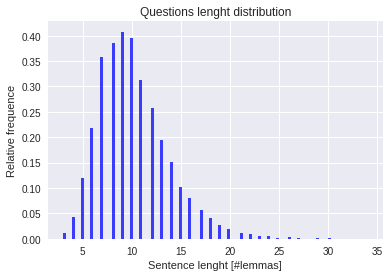

mu=10.21, sigma=3.61


In [16]:
largos = []

for i in tqdm(range(len(test_questions))):
    largos.append(len(test_questions[i]))

sigma = np.std(largos)
mu = np.average(largos)

# the histogram of the data
n, bins, patches = plt.hist(largos, 100, normed=1, facecolor='blue', alpha=0.75)

titulo = 'mu={0:.2f}, sigma={1:.2f}'.format(mu,sigma)

plt.xlabel('Sentence lenght [#lemmas]')
plt.ylabel('Relative frequence')
plt.title('Questions lenght distribution')
plt.grid(True)

plt.show()

print(titulo)

El largo de las preguntas de test se encuentra en un rango bastante similar al del conjunto de entrenamiento.

In [17]:
lemasTest = set()
for i in tqdm(range(len(test_questions))):
    for lema in test_questions[i]:
        lemasTest.add(lema)

lemasTest = list(lemasTest)    
    
print("Ammount of lemas:", len(lemasTest))

100%|██████████| 11873/11873 [00:00<00:00, 315716.88it/s]

Ammount of lemas: 10320


In [20]:
i=0

NlemasTest = np.empty(len(lemasTest))

for lema in tqdm(lemasTest):
    NlemasTest[i]= sum(question.count(lema) for question in test_questions)
    i+=1

100%|██████████| 10320/10320 [00:39<00:00, 264.23it/s]


In [21]:
sortedLemmasTest = sorted(zip(lemasTest,NlemasTest), reverse=True, key=lambda pair: pair[1])
nTop = 10
i=0
print('{0:^20}|{1:^15}'.format('Lemma', 'Ammount'))
print('-'*36)
for (l, n) in sortedLemmasTest:
  print('{0:^20}|{1:^15.0f}'.format(l, n))
  i+=1
  if i >= nTop:
    break

       Lemma        |    Ammount    
------------------------------------
        the         |     8426      
        what        |     7512      
         of         |     4715      
         in         |     3359      
         to         |     2699      
         is         |     2676      
        did         |     1825      
        was         |     1803      
         a          |     1758      
        how         |     1292      


Se observa que los lemas más repetidos en el conjunto de test corresponden de manera casi 1 a 1 con el conjunto de entrenamiento.

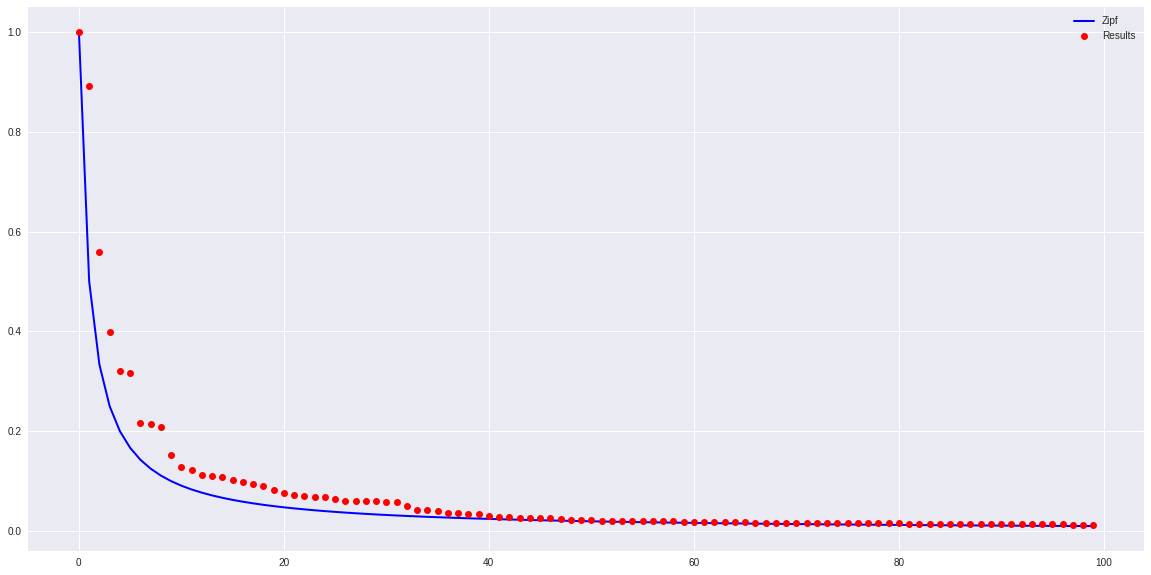

In [22]:
max_repeat = sortedLemmasTest[0][1]
plt.figure(figsize=(20,10))
plt.plot(list(range(100)), [1/(i+1) for i in range(100)], 'b-', linewidth=2, label='Zipf')
plt.plot(list(range(100)), [y/max_repeat for (_, y) in sortedLemmasTest[0:100]], 'ro', label='Results')
plt.legend(loc='best')
plt.show()

Ahora, para efectos de construir un vocabulario completo, se unirán los lemas de ambos conjuntos

In [18]:
vocab_question = set()

for lema in lemas:
    vocab_question.add(lema)
    
for lema in lemasTest:
    vocab_question.add(lema)
    
print("Vocabulary size:", len(list(vocab_question)))

Vocabulary size: 42058


Considerando que:
$$\#\text{Lemas}_{\text{train}}=39480$$
$$\#\text{Lemas}_{\text{test}}=10320$$
$$\#(\text{Lemas}_{\text{train}}\cup\text{Lemas}_{\text{test}})=42058$$
$$\#(\text{Lemas}_{\text{train}}\cap\text{Lemas}_{\text{test}})=7742$$

Esto implica que en el conjunto de pruebas existen $2578$ lemas que no existen en el conjunto de entrenamiento, lo cual puede ocasionar problemas en la predicción, sobre todo porque los lemas serán codificados haciendo imposible una relación entre los lemas aprendidos y los nuevos.

Edit Post Presentación: Ahora se considera que unificar los vocabularios es contraproducente, ya que se incrementa la dimensionalidad de la entrada para representar palabras que no serán utilizadas en el entrenamiento. Pudiendo esto afectar la capacidad predictiva del modelo, ya que se necesitan de más parámetros para modelar el ingreso de las nuevos lemas.

> c) Cree un vocabulario para codificar las palabras en las respuestas a generar. Repita el procedimiento para las preguntas. Agrege un símbolo que signifique el fin de la respuesta a generar, así para tener un criterio de cuando una respuesta, valga la redundancia, está efectivamente *respondida* ¿Cuántas palabras tiene el vocabulario de las respuestas y de las preguntas? ¿Ésto podría ser un problema al momento de entrenar la red para que predizca de entre todas ellas?

```python
vocab_answer = set()
for sentence in train_answers:
    for word in sentence:
        vocab_answer.add(word)
vocab_answer = ["#end"]+ list(vocab_answer)
print('posibles palabras para respuestas :', len(vocab_answer))
vocabA_indices = {c: i for i, c in enumerate(vocab_answer)}
indices_vocabA = {i: c for i, c in enumerate(vocab_answer)}
#sameforquestions
```

In [19]:
vocab_answer = set()
for sentence in train_answers:
    for word in sentence:
        vocab_answer.add(word)
vocab_answer = ["#end"]+ list(vocab_answer)
print('posibles palabras para respuestas :', len(vocab_answer))
vocabA_indices = {c: i for i, c in enumerate(vocab_answer)}
indices_vocabA = {i: c for i, c in enumerate(vocab_answer)}
#sameforquestions

posibles palabras para respuestas : 47423


In [0]:
vocab_question = ["#end"]+ list(vocab_question)
vocabQ_indices = {c: i for i, c in enumerate(vocab_question)}
indices_vocabQ = {i: c for i, c in enumerate(vocab_question)}

> d) Codifique los tokens (palabras) de cada texto que utilizará.

```python
#input and output to onehotvector
X_answers = [[vocabA_indices[palabra] for palabra in sentence] for sentence in train_answers]
Xtrain_question = #same for train question
Xtest_question = #same for test question
```

In [0]:
#input and output to onehotvector
X_answers = [[vocabA_indices[palabra] for palabra in sentence] for sentence in train_answers]
Xtrain_question = [[vocabQ_indices[palabra] for palabra in sentence] for sentence in train_questions]
Xtest_question = [[vocabQ_indices[palabra] for palabra in sentence] for sentence in test_questions]

> Luego de ésto realice un *padding* a ambas secuencias, entrada y salida de entrenamiento y a la entrada del conjunto de pruebas. Comente sobre las dimensionalidades finales de los conjuntos de entrenamiento y de prueba.

```python
import numpy as np
max_input_lenght = np.max(list(map(len,train_questions)))
max_output_lenght = np.max(list(map(len,train_answers)))+1
from keras.preprocessing import sequence
Xtrain_question = sequence.pad_sequences(Xtrain_question,maxlen=max_input_lenght,padding='pre or post',value=0)
Xtest_question = sequence.pad_sequences(Xtest_question,maxlen=max_input_lenght,padding='pre or post',value=0)
X_answers = sequence.pad_sequences(X_answers,maxlen=max_output_lenght,padding='post',value=vocabA_indices["#end"])
```

In [0]:
max_input_lenght = np.max([np.max(list(map(len,train_questions))),np.max(list(map(len,test_questions)))])
max_output_lenght = np.max(list(map(len,train_answers)))+1

Xtrain_question = sequence.pad_sequences(Xtrain_question,maxlen=max_input_lenght,padding='post',value=vocabQ_indices["#end"])
Xtest_question = sequence.pad_sequences(Xtest_question,maxlen=max_input_lenght,padding='post',value=vocabQ_indices["#end"])
X_answers = sequence.pad_sequences(X_answers,maxlen=max_output_lenght,padding='post',value=vocabA_indices["#end"])

Se define el tamaño máximo de entrada como el máximo entre el largo de las preguntas de entrenamiento y pruebas, para mantener consistencia y que la red pueda ser efectivamente alimentada con los datos de prueba.

In [23]:
print("Size training input set:", Xtrain_question.shape)
print("Size testing input set:", Xtest_question.shape)
print("Size training output set:", X_answers.shape)

Size training input set: (86821, 59)
Size testing input set: (11873, 59)
Size training output set: (86821, 47)


Por el análisis de los conjuntos de preguntas, se sabe que el largo de las secuencias es en promedio de $11$ elementos por lo que la mayoría de las secuencias codificadas presentarán más de la mitad de su largo rellenas con $0$.
Las pregunta más larga contiene 59 lemas, mientras que la respuesta más larga contiene 46+1 palabras considerando el caracter de término.

> e) Defina el modelo *encoder-decoder* con los módulos de atención.

```python
#Encoder-Decoder modelo
from keras.layers import Input,RepeatVector,TimeDistributed,Dense,Embedding,Flatten,Activation,Permute,Lambda
from keras.models import Model
from keras import backend as K
lenght_output = max_output_lenght
hidden_dim = 128
```

In [0]:
lenght_output = max_output_lenght
hidden_dim = 128

> Defina el *encoder* y las compuertas que utilizará: CuDNNGRU,CuDNNLSTM, RNN u otra. Puede utilizar redes bidireccionales en el *encoder* ¿Esto mejora el resultado?

```python
embedding_vector = 64 
encoder_input = Input(shape=(max_input_lenght,))
embedded = Embedding(input_dim=len(vocabQ_indices),output_dim=embedding_vector,input_length=max_input_lenght)(encoder_input)
encoder = gate(hidden_dim, return_sequences=True)(embedded)
```

In [0]:
embedding_vector = 64 
encoder_input = Input(shape=(max_input_lenght,))
embedded = Embedding(input_dim=len(vocabQ_indices),output_dim=embedding_vector,input_length=max_input_lenght)(encoder_input)
encoder = CuDNNGRU(hidden_dim, activity_regularizer=regularizers.l2(0.01),return_sequences=True)(embedded)
encoder = Dropout(0.5)(encoder)

> Defina la atención $\alpha$ que se calculará sobre cada instante de tiempo $T$ computándo su atención en cada instante de tiempo de la decodificación $T'$.

```python
# compute T' importance for each step T
attention = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder)
#softmax a las antenciones sobre todo T
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention) 
attention = Permute([2, 1])(attention)
```

In [0]:
# compute T' importance for each step T
attention = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder)
#softmax a las antenciones sobre todo T
attention = Permute([2, 1])(attention)
attention = Activation('softmax')(attention) 
attention = Permute([2, 1])(attention)

> Aplique la atención sobre el *encoder* y genere las salidas correspondientes.

```python
# apply the attention to encoder
def attention_multiply(vects):
    encoder, attention = vects
    return K.batch_dot(attention,encoder, axes=1)
sent_representation = Lambda(attention_multiply)([encoder, attention])
decoder = gate(hidden_dim, return_sequences=True)(sent_representation)
probabilities = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder)
```

In [0]:
# apply the attention to encoder
def attention_multiply(vects):
    encoder, attention = vects
    return K.batch_dot(attention,encoder, axes=1)
sent_representation = Lambda(attention_multiply)([encoder, attention])
decoder = CuDNNGRU(hidden_dim, return_sequences=True)(sent_representation)
probabilities = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder)

> Defina el modelo y descríbalo adecuadamente.

```python
model = Model(encoder_input,probabilities)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()
```

In [28]:
model = Model(encoder_input,probabilities)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 59)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 59, 64)       2691776     input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 59, 128)      74496       embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 59, 128)      0           cu_dnngru_1[0][0]                
__________________________________________________________________________________________________
time_distr

Luego de variar la arquitectura en distinta ocasiones por la presencia de un fuerte *overfitting* en los primeros *epochs*, se opta por implementar un regularizador $l_2$ a la capa que actúa como encoder, además de un subsecuente *Dropout* para reducir el fecto anteriormente mencionado. En un principio se pensó utilizar las mismas técnicas para reducir *overfitting* sobre el decoder, sin embargo esto incrementaba en demasía el tiempo de entrenamiento, a la vez que no producía mejoras relevantes respecto a la perdida del modelo.

Además, tanto para el encoder como el decoder se utilizan capas de tipo GRU, esto por la menor cantidad que parámetros entrenables que poseen. 

> f) Entrene el modelo por 10 *epochs* con el tamaño de batch que estime conveniente. Para ésto deberá redimensionar la salida para que tenga 3 dimensiones debido a la recurrencia.

```python
X_answers = X_answers.reshape(X_answers.shape[0],X_answers.shape[1],1)
X_answers.shape
model.fit(Xtrain_question,X_answers,epochs=10,batch_size=BS,validation_split=0.2)
```
*Por temas de recursos puede optar con entrenar con una muestra más pequeña del conjunto de entrenamiento*.


In [29]:
X_answers = X_answers.reshape(X_answers.shape[0],X_answers.shape[1],1)
X_answers.shape
hist = model.fit(Xtrain_question,X_answers,epochs=10,batch_size=256,validation_split=0.2)


Train on 69456 samples, validate on 17365 samples
Epoch 1/10
69456/69456 [==============================] - 355s 5ms/step - loss: 2.1055 - val_loss: 0.9162
Epoch 2/10
69456/69456 [==============================] - 353s 5ms/step - loss: 0.8174 - val_loss: 0.8907
Epoch 3/10
69456/69456 [==============================] - 354s 5ms/step - loss: 0.7675 - val_loss: 0.8335
Epoch 4/10
69456/69456 [==============================] - 354s 5ms/step - loss: 0.7357 - val_loss: 0.8252
Epoch 5/10
69456/69456 [==============================] - 354s 5ms/step - loss: 0.7285 - val_loss: 0.8239
Epoch 6/10
69456/69456 [==============================] - 354s 5ms/step - loss: 0.7225 - val_loss: 0.8201
Epoch 7/10
69456/69456 [==============================] - 354s 5ms/step - loss: 0.7165 - val_loss: 0.8164
Epoch 8/10
69456/69456 [==============================] - 354s 5ms/step - loss: 0.7111 - val_loss: 0.8143
Epoch 9/10
69456/69456 [==============================] - 354s 5ms/step - loss: 0.7068 - val_loss: 0.8

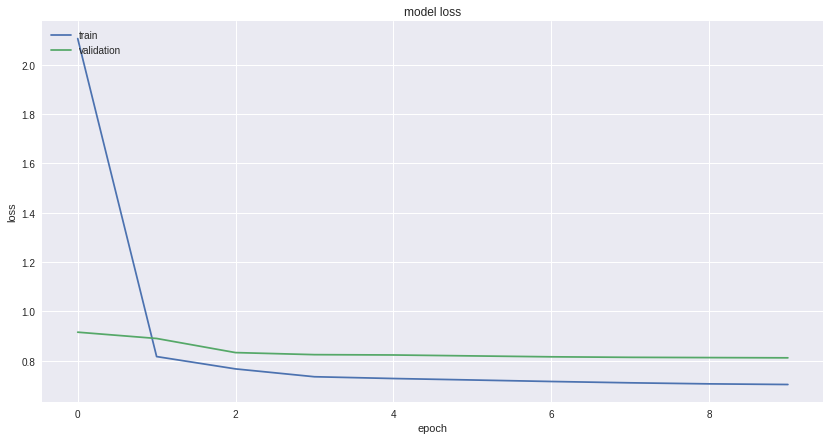

In [30]:
plt.figure(figsize=(14,7))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Se entrenó tanto este modelo como el que sigue durante 25 *epochs* y en ambos se observó la tendencia al *overfitting*, revelado por un *val_loss* en crecimiento luego del *epoch* 10 u 11. Por esto, se decide entrenar la red solo por 10 *epochs* en ambos casos, donde parece existir un mínimo local del valor mencionado.

En la gráfica de este modelo se observa que loss de entrenamiento disminuye hasta estancarse cerca del valor de $0.7$, mientras que el *val_loss* disminue tímidamente hasta las cercanías de $0.8$.

Para comparar la calidad de los resultados obtenidos, se entrenará un modelo con una arquitectura equivalente, pero implementando una característica **bidireccional** en ambas **GRUs**.

In [33]:
encoder2 = Bidirectional(CuDNNLSTM(hidden_dim, activity_regularizer=regularizers.l2(0.01), return_sequences=True))(embedded)
encoder2 = Dropout(0.5)(encoder2)
# compute T' importance for each step T
attention2 = TimeDistributed(Dense(max_output_lenght, activation='tanh'))(encoder2)
#softmax a las antenciones sobre todo T
attention2 = Permute([2, 1])(attention2)
attention2 = Activation('softmax')(attention2) 
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Lambda(attention_multiply)([encoder2, attention2])
decoder2 = CuDNNGRU(hidden_dim, return_sequences=True)(sent_representation2)
probabilities2 = TimeDistributed(Dense(len(vocab_answer), activation="softmax"))(decoder2)
model2 = Model(encoder_input,probabilities2)
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 59)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 59, 64)       2691776     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 59, 256)      198656      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 59, 256)      0           bidirectional_2[0][0]            
__________________________________________________________________________________________________
time_distr

Se observa un leve incremento en la cantidad de parámetros entrenable de la red.

In [34]:
hist2 = model2.fit(Xtrain_question,X_answers,epochs=10,batch_size=256,validation_split=0.2)

Train on 69456 samples, validate on 17365 samples
Epoch 1/10
69456/69456 [==============================] - 360s 5ms/step - loss: 1.9988 - val_loss: 0.9097
Epoch 2/10
69456/69456 [==============================] - 361s 5ms/step - loss: 0.8136 - val_loss: 0.8879
Epoch 3/10
69456/69456 [==============================] - 361s 5ms/step - loss: 0.7645 - val_loss: 0.8293
Epoch 4/10
69456/69456 [==============================] - 361s 5ms/step - loss: 0.7340 - val_loss: 0.8215
Epoch 5/10
69456/69456 [==============================] - 361s 5ms/step - loss: 0.7271 - val_loss: 0.8193
Epoch 6/10
69456/69456 [==============================] - 361s 5ms/step - loss: 0.7210 - val_loss: 0.8170
Epoch 7/10
69456/69456 [==============================] - 361s 5ms/step - loss: 0.7149 - val_loss: 0.8133
Epoch 8/10
69456/69456 [==============================] - 361s 5ms/step - loss: 0.7095 - val_loss: 0.8116
Epoch 9/10
69456/69456 [==============================] - 361s 5ms/step - loss: 0.7058 - val_loss: 0.8

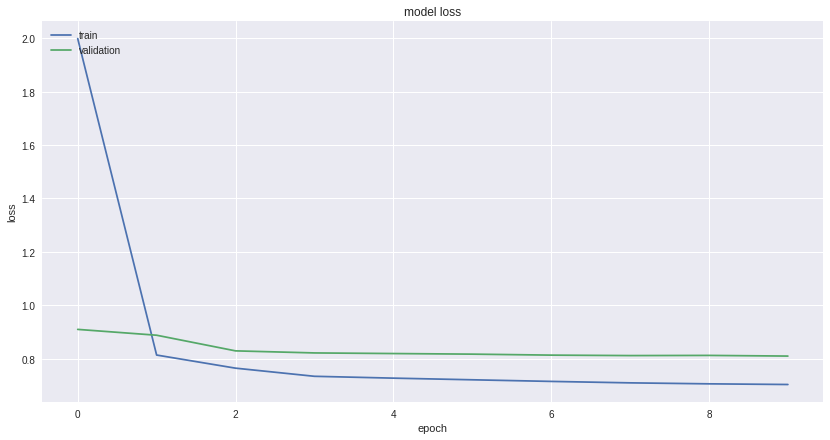

In [39]:
plt.figure(figsize=(14,7))
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Se observa una leve mejor respecto de la contraparte **unidireccional**, en el valor de *loss* obtenido para el entrenamiento y validación, a costa de al rededor de un minuto extra de entrenamiento.

> g) Muestre ejemplos de la predicción del modelo, para ésto genere una función que prediga a través de la distribución de probabilidad de la salida, de la forma que estime conveniente, cada palabra en cada instante de tiempo.

```python
def predict_words(model,example,diversity=?):
    #predict example
n=10
for i in range(n):
    indexs = np.random.randint(0,len(Xtest_question))
    example = Xtest_question[indexs]
    indexes_answer = predict_words(model,example,0.85)
    question = df_test["question"][indexs]
    print("Pregunta: ",question)
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    print("Respuesta: ",answer)
print("Los ha predecido todos!")
```

In [0]:
def predict_words(model,example,diversity=0): #diversity: number between 0 and 1
  
  if diversity>1 or diversity<0:
    return null
  
  output = model.predict(np.array([example]))
  answer = []
  nWords = output.shape[2]
  
  #flag = True
  
  for wordProbs in output[0]:
    iWord=0
    sortedIndexes = np.argsort(wordProbs)[::-1][:]
    selected = sortedIndexes[0]
    
    #if flag:
    #  print(selected)
      
    if diversity>0:
      while choice([True, False], p=[diversity,1-diversity]):
        selected = sortedIndexes[iWord]
        if iWord == nWords-1:
          break
        iWord+=1
        
    answer.append(selected)
    
    #if flag:
    #  print(selected)
    
    flag=False
    
  return answer

La función definida predice la salida de una pregunta a partir de un modelo, donde esta está consituida por $47$ vectores representando posiciones de palabras en la respuesta, donde cada vector posee $47423$ componentes, representando la probabilidad de que la palabra del vocabulario correspondiente por codificación ocupe la posición en la respuesta. (Las dos dimensiones mencionada se encuentran encapsuladas en un vector, pero este no tiene relevancia para el análisis)

A partir, de esta salida se ordenan los índices de cada vector de mayor a menor probabilidad, correspondiendo estos índices con el vocabulario de las respuestas. Luego, con el parámetro diversity, se puede decidir si descartar la palabra con mayor probabilidad y seleccionar la siguiente, esto según un lanzamiento de moneda cada vez.

Finalmente, los índices seleccionados son guardados en un vector y retornados.

In [59]:
n=10
for i in range(n):
    indexs = np.random.randint(0,len(Xtest_question))
    example = Xtest_question[indexs]
    indexes_answer = predict_words(model,example,0.5)
    question = df_test["question"][indexs]
    print("Pregunta: ",question)
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    print("Respuesta: ",answer)
print("Los ha predecido todos!")

Pregunta:  What cultures were part of Kublai's administration?
Respuesta:  the and the and the and and the . . of the , , . 
Pregunta:  If the head of government refuses to enforce a decision of the highest court what terminology could be used?
Respuesta:  the the the , , , of , and the the . . the , 
Pregunta:  Who didn't Abercrombie replace as commander in chief?
Respuesta:  a the the , , the the , the and the the . to , 
Pregunta:  To force Japan to be more involved in the crisis, what did Saudi and Kuwaiti government do?
Respuesta:  the the and , , the the the . of the of 
Pregunta:  What sort of engines utilized the Yarrow-Schlick-Tweedy balancing system?
Respuesta:  the , , the , and the the . the 
Pregunta:  What district of Warsaw chose the President between 1994 and 1999?
Respuesta:  the , , , . the . the . 
Pregunta:  How does the TFEU revise old legislation?
Respuesta:  the of the of the , and , the the . the 
Pregunta:  NSF helped the network enhance what?
Respuesta:  the o

Lo anterior corresponde a las respuestas construídas a partir del modelo **unidireccional**, luego de lo que el notebook de Google Colab se desincronizó, perdiéndose los modelos entrenados.

Se observa que el parámetro diversity $0.5$ le permite al modelo construir respuestas de largo variado, esto se contrasta respecto a lo obtenido si se elige la palabra con mayor probabilidad en cada caso, ya que esto ocasiona que la mayoría de las respuestas sean de largo de un caracter siendo este caracter *'the'*. De nuevo, no se muestra este escenario por problemas con Google Colab.

Por estos problemas con la plataforma es que no se ejecuta una evaluación del modelo en el siguiente item, hasta este momento aún no existen GPUs disponibles para realizar el trabajo.

> h) Evalúe la calidad de su modelo con la métrica del *benchmark*, para ésto deberá descargar el archivo **evaluation script** y el dato **dev json** de la página oficial del dataset: https://rajpurkar.github.io/SQuAD-explorer/ y ejecutarlo de la siguiente manera dentro del *Jupyter Notebook*

```python
#evaluar resultados
!python evaluate-v2.0.py dev-v2.0.json predictions
```

> Para generar las predicciones utilice la función anteriormente definida de la siguiente manera:
```python
dic_predictions = {}
for example,id_e in zip(Xtest_question,df_test["id"]): #todos los ejemplos
    indexes_answer = predict_words(model,example) #predice palabra en cada instante
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    dic_predictions[id_e] = answer
    contador+=1
print("Los ha predecido todos!")
json_save = json.dumps(dic_predictions)
archivo = open("predictions","w")
archivo.write(json_save)
archivo.close()
```
Comente sobre el desempeño obtenido y a qué debiera deberse.

Asumiendo un desempeño como el visto en las presentaciones ya que se tiene un resultado muy similar a estos, se puede atribuir la baja performance a la poca información con la que se alimenta la red, y a una pobre elección de vocabulario.

In [0]:
dic_predictions = {}
for example,id_e in tqdm(zip(Xtest_question,df_test["id"])): #todos los ejemplos
    indexes_answer = predict_words(model,example,0.85) #predice palabra en cada instante
    answer = ""
    for index in indexes_answer:
        if indices_vocabA[index]=="#end": # el final de la oracion
            continue
        else:
            answer+=indices_vocabA[index]+" "
    dic_predictions[id_e] = answer
    
print("Los ha predecido todos!")
json_save = json.dumps(dic_predictions)
archivo = open("predictions","w")
archivo.write(json_save)
archivo.close()

In [0]:
!python evaluate-v2.0.py dev-v2.0.json predictions

<a id="refs"></a>
## Referencias
[1] Kingma, D. P., & Welling, M. (2013). *Auto-encoding variational bayes*. arXiv preprint arXiv:1312.6114.  
[2] Dumoulin, V., & Visin, F. (2016). *A guide to convolution arithmetic for deep learning*. arXiv preprint arXiv:1603.07285.  
[3] https://github.com/vdumoulin/conv_arithmetic  
[4] Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). *Generative adversarial nets*. In Advances in neural information processing systems (pp. 2672-2680).  
[5] Joyce, J. M. (2011). *Kullback-leibler divergence*. In International Encyclopedia of Statistical Science (pp. 720-722). Springer Berlin Heidelberg.  
[6] Chorowski, J. K., Bahdanau, D., Serdyuk, D., Cho, K., & Bengio, Y. (2015). *Attention-based models for speech recognition*. In Advances in neural information processing systems (pp. 577-585).